In [1]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
from scipy.stats import multivariate_normal
import pandas as pd
import sklearn
from sklearn.datasets import load_wine
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pickle

In [2]:
with open('./problem4-dataset3/colors.pkl','rb') as file:
    data = pickle.load(file)
data.shape

(100, 2)

In [3]:
# from earlier question
class GMM():
    def __init__(self):
        self.weights = None
        self.means = None
        self.covariances = None
        self.n_components = None

    def initialize_parameters(self, data, n_components):
        self.n_components = n_components
        self.weights = np.ones(self.n_components) / self.n_components
        self.reduced_pca_data = data
        self.means = self.reduced_pca_data[np.random.choice(self.reduced_pca_data.shape[0], self.n_components, replace=False), :]
        self.covariances = [np.cov(self.reduced_pca_data, rowvar=False)] * self.n_components

    def e_step(self, data):
        responsibilities = np.zeros((data.shape[0], self.n_components))
        for i in range(self.n_components):
            responsibilities[:, i] = self.weights[i] * multivariate_normal(self.means[i], self.covariances[i]).pdf(data)
        
        responsibilities = responsibilities / responsibilities.sum(axis=1, keepdims=True)
        
        return responsibilities

    def m_step(self, data, responsibilities):
        for i in range(self.n_components):
            weight = responsibilities[:, i].sum()
            mean = (data * responsibilities[:, i, np.newaxis]).sum(axis=0) / weight
            covariance = np.dot((responsibilities[:, i, np.newaxis] * (data - mean)).T, (data - mean)) / weight

            self.weights[i] = weight / data.shape[0]
            self.means[i] = mean
            self.covariances[i] = covariance

    def compute_log_likelihood(self):
        log_likelihood = 0
        for i in range(self.n_components):
            log_likelihood += self.weights[i] * multivariate_normal(self.means[i], self.covariances[i]).pdf(self.reduced_pca_data)
        return np.log(log_likelihood).sum()

    def fit(self, data, n_components,tol=1e-4, max_iter=10000):
        self.initialize_parameters(data, n_components)
        log_likelihood = 0
        for iteration in range(max_iter):
            responsibilities = self.e_step(self.reduced_pca_data)
            self.m_step(self.reduced_pca_data, responsibilities)
            new_log_likelihood = self.compute_log_likelihood()
            
            if abs(new_log_likelihood - log_likelihood) < tol:
                break
            log_likelihood = new_log_likelihood

    def get_parameters(self):
        return {
            "weights": self.weights,
            "means": self.means,
            "covariances": self.covariances
        }

    def predict(self, data):
        likelihoods = np.zeros((data.shape[0], self.n_components))
        for i in range(self.n_components):
            likelihoods[:, i] = self.weights[i] * multivariate_normal(self.means[i], self.covariances[i]).pdf(data)
        return likelihoods

    def predict_membership(self):
        responsibilities = self.e_step(self.reduced_pca_data)
        return responsibilities.argmax(axis=1)

    def compute_aic(self):
        k = self.n_components * (self.reduced_pca_data.shape[1] + self.reduced_pca_data.shape[1] * (self.reduced_pca_data.shape[1] + 1) / 2 + 1)
        log_likelihood = self.compute_log_likelihood()
        aic = 2*k - 2*log_likelihood
        return aic

    def compute_bic(self):
        k = self.n_components * (self.reduced_pca_data.shape[1] + self.reduced_pca_data.shape[1] * (self.reduced_pca_data.shape[1] + 1) / 2 + 1)
        log_likelihood = self.compute_log_likelihood()
        bic = np.log(self.reduced_pca_data.shape[0]) * k - 2 * log_likelihood
        return bic

In [4]:
gmm_model = GMM()

In [5]:
gmm_model.fit(data,n_components=7)

In [6]:
gmm_model.get_parameters()

{'weights': array([0.17      , 0.17      , 0.29      , 0.08      , 0.2       ,
        0.03070919, 0.05929081]),
 'means': array([[ 9.95904977e-02,  1.26934805e+02],
        [ 2.55165668e+02,  1.27358500e+02],
        [ 1.93150109e+02, -1.48663771e-01],
        [ 1.26931688e+02,  2.54851953e+02],
        [ 1.27172922e+02,  1.26605367e+02],
        [-1.85056695e-01,  2.54263077e+02],
        [ 5.01806524e-01,  2.54650281e+02]]),
 'covariances': [array([[1.6740456 , 0.30152784],
         [0.30152784, 0.89468441]]),
  array([[ 1.02962702, -0.03525602],
         [-0.03525602,  0.57207545]]),
  array([[ 4.07655137e+03, -4.05464852e+00],
         [-4.05464852e+00,  8.42238281e-01]]),
  array([[1.09300803, 0.05372962],
         [0.05372962, 0.93233438]]),
  array([[ 1.19754433, -0.01923169],
         [-0.01923169,  1.70463677]]),
  array([[1.12718393, 1.37309409],
         [1.37309409, 1.75186213]]),
  array([[ 1.74245176, -0.04455929],
         [-0.04455929,  0.03684222]])]}

In [7]:
# predict cluster for each point
predictions = gmm_model.predict_membership()

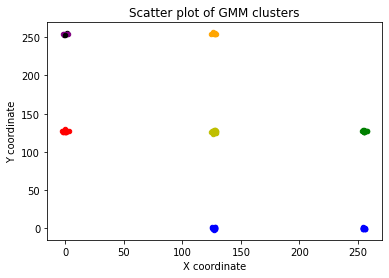

In [8]:
# making a plot for scatter
color = ['r','g','b','orange','y','black','purple']
for i,sample in enumerate(data):
    plt.scatter(sample[0],sample[1],s=20,color=color[predictions[i]])
plt.title('Scatter plot of GMM clusters')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()

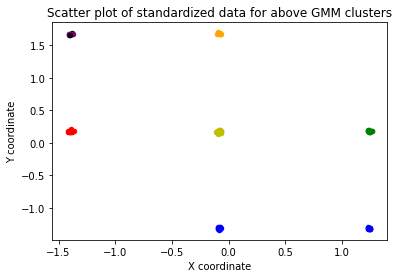

In [9]:
# after standardizing a more clear view
color = ['r','g','b','orange','y','black','purple']

std_data = (data-np.mean(data,axis=0))/np.std(data,axis=0)
for i,sample in enumerate(std_data):
    plt.scatter(sample[0],sample[1],s=20,color=color[predictions[i]])
plt.title('Scatter plot of standardized data for above GMM clusters')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()

>

<h3>Generating data from the Gaussian Components</h3>

In [21]:
def generate_dataset(n, means, covariances,cluster_labels):
    data = []

    for i in range(n):
        # generates 200 samples from each gauissian
        each_sample_data = np.random.multivariate_normal(means[i], covariances[i], size=200)
        for da in range(200):
            cluster_labels.append(i)
        data.append(each_sample_data)

    dataset = np.vstack(data)
    return dataset

In [22]:
# number of components, means and covariances
n = 2
clusters_labels=[]
means = np.array([[2, 2], [5, 5]])
covariances = np.array([
    [[2, 0], [3, 0]],
    [[0, 1], [0, 1]]
])

sample_dataset = generate_dataset(n, means, covariances,clusters_labels)
print(sample_dataset.shape)

(400, 2)


/tmp/ipykernel_226373/2446119882.py:6: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  each_sample_data = np.random.multivariate_normal(means[i], covariances[i], size=200)


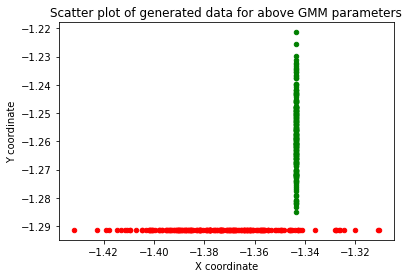

In [24]:
# making a plot

# after standardizing a more clear view
color = ['r','g','b','orange','y','black','purple']

std_data = (sample_dataset-np.mean(data,axis=0))/np.std(data,axis=0)

for i,sample in enumerate(std_data):
    plt.scatter(sample[0],sample[1],s=20,color=color[clusters_labels[i]])
    
plt.title('Scatter plot of generated data for above GMM parameters')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()

## Observations

1) The mean of the sample observation is close to the mean of the component, indicating a typical value for that cluster.

2) Since we have multiple Gaussian components, the data generated from a particular component, that particular sample of data is going to belong to the cluster associated with that particular mean as observed by the plot also.